# Instructions
Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!

### Load initial packages

In [2]:
from modsim import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import simpy as sp


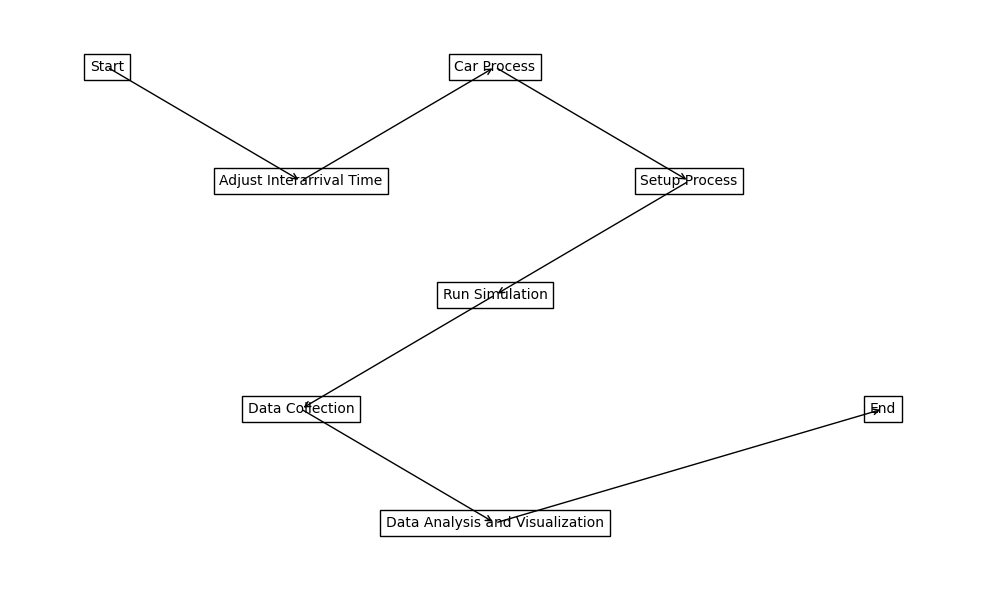

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Function to draw an arrow
def draw_arrow(ax, start, end):
    ax.annotate("", xy=end, xycoords='data', xytext=start, textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Nodes as points [(x, y), ...]
nodes = {'Start': (1, 9), 'Adjust Interarrival Time': (3, 7), 'Car Process': (5, 9),
         'Setup Process': (7, 7), 'Run Simulation': (5, 5), 'Data Collection': (3, 3),
         'Data Analysis and Visualization': (5, 1), 'End': (9, 3)}

# Draw nodes
for node, (x, y) in nodes.items():
    ax.text(x, y, node, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

# Draw edges
edges = [('Start', 'Adjust Interarrival Time'), ('Adjust Interarrival Time', 'Car Process'),
         ('Car Process', 'Setup Process'), ('Setup Process', 'Run Simulation'),
         ('Run Simulation', 'Data Collection'), ('Data Collection', 'Data Analysis and Visualization'),
         ('Data Analysis and Visualization', 'End')]

for start, end in edges:
    start_pos, end_pos = nodes[start], nodes[end]
    draw_arrow(ax, start_pos, end_pos)

plt.tight_layout()
plt.show()

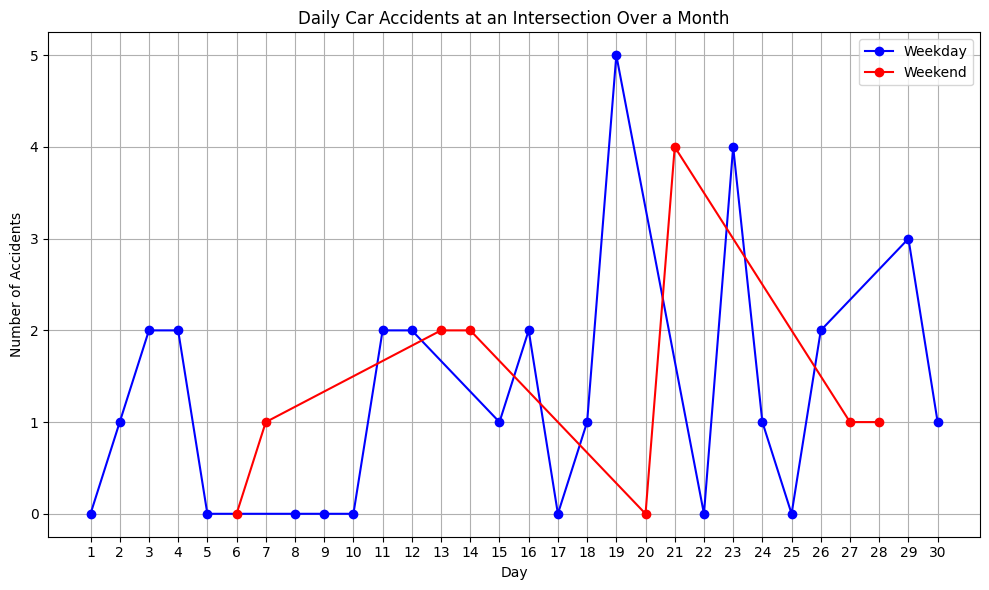

In [9]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants
DAYS_IN_MONTH = 30
TOTAL_CARS = 30000
BASE_INTERARRIVAL_TIME = DAYS_IN_MONTH * 24 * 60 * 60 / TOTAL_CARS  # Base spread of cars over the month

# Time periods (in hours)
MORNING_PEAK_START, MORNING_PEAK_END = 6, 10
EVENING_PEAK_START, EVENING_PEAK_END = 16, 20
WEEKEND = [5, 6]  # Saturday and Sunday

def adjust_interarrival_time(current_time):
    """Adjust interarrival time based on the current simulation time."""
    hour = (current_time // (60*60)) % 24
    day = (current_time // (24*60*60)) % 7
    
    if day in WEEKEND:
        return BASE_INTERARRIVAL_TIME * 1.5  # Slower on weekends
    elif MORNING_PEAK_START <= hour < MORNING_PEAK_END or EVENING_PEAK_START <= hour < EVENING_PEAK_END:
        return BASE_INTERARRIVAL_TIME * 0.5  # Busier in morning and evening
    else:
        return BASE_INTERARRIVAL_TIME * 1.2  # Slower in the afternoon

class Intersection:
    def __init__(self, env):
        self.env = env
        self.accidents = 0

    def pass_through(self):
        if random.random() < 0.001:  # Adjusted probability for demonstration
            self.accidents += 1

def car(env, intersection):
    intersection.pass_through()
    yield env.timeout(1)
    if random.random() < 0.3:
        yield env.timeout(random.randint(1, 10))
        intersection.pass_through()

def setup(env, intersection):
    while True:
        interarrival_time = adjust_interarrival_time(env.now)
        yield env.timeout(interarrival_time)
        env.process(car(env, intersection))

results = []
for day in range(1, DAYS_IN_MONTH + 1):
    env = simpy.Environment()
    intersection = Intersection(env)
    env.process(setup(env, intersection))
    env.run(until=24*60*60)
    day_type = 'Weekend' if day % 7 in [6, 0] else 'Weekday'  # Assuming 1st day is a Monday
    results.append({'Day': day, 'Accidents': intersection.accidents, 'DayType': day_type})

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Weekdays
weekdays = df[df['DayType'] == 'Weekday']
plt.plot(weekdays['Day'], weekdays['Accidents'], marker='o', linestyle='-', label='Weekday', color='blue')

# Plot Weekends
weekends = df[df['DayType'] == 'Weekend']
plt.plot(weekends['Day'], weekends['Accidents'], marker='o', linestyle='-', label='Weekend', color='red')

plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.title('Daily Car Accidents at an Intersection Over a Month')
plt.xticks(range(1, DAYS_IN_MONTH + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()